In [1]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda, float64, int64
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
from scipy import integrate as scint
# import torch
# from core import weights

read icdata
read uptdata
read eadata
read mspdata


/home/darkwake/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
os.getcwd()

'/media/darkwake/VIB2/Project-IceCube/package'

In [3]:
num_threads = int(mul.cpu_count()*0.8)
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
set_num_threads(num_threads)
PI = np.pi

In [4]:

# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

master_nbins = int(1e6)
# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.float64(np.logspace(11.001, 18.999, master_nbins))

decl_bins=master_nbins//1000
decls = np.rad2deg(np.linspace(-np.pi/2, np.pi/2 - 1e-40, decl_bins))


enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
    
    
decls_bin_indices = np.zeros(len(decls), dtype=np.int64)

for i in prange(decl_bins):
    decls_bin_indices[i] = np.digitize(decls[i], dec_nu) - 1

decls_bin_indices[-1] -= 1

decls = np.deg2rad(decls)

msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

gamma_arr = np.asfarray([-2, -2.2, -2.53, -3], dtype=np.float64)

In [5]:
np.digitize(np.array([0, 1, 2]), np.linspace(0, 11, 12))

array([1, 2, 3])

In [6]:
@vectorize([float64(int64, int64, float64)], nopython=True, target='parallel')
def ns_newhat(decl_index, season, gamma):
    '''
    EQN 10 OF 2103.12813
    -------------------
    
    Parameters
    ----------
    decl_index : int64
        The index of the declination bin
    season : int64
        The index of the season
    gamma : float64
        The spectral index of the neutrino flux
    Returns
    -------
    float64
        The number of signal events for a single pulsar as in EQN10 of 2103.12813
    '''
    
    
    temp = dfde(enus, gamma, 1) * enus# * np.cos(decls[decl_index])
    temp2 = earea[ea_season(season)][(decls_bin_indices[decl_index] * 40 + enus_bin_indices).astype(np.int64)].astype(np.float64)
    temp = temp * temp2
    return np.trapz(temp, enus)


In [7]:
#pickle
if f'all_ns_HAT_spl_{len(enus)}_x_{len(decls)}.pkl' in os.listdir(altier_path[0]):
    print("Loading ns_spl from pickle")
    with open(altier_path[0] + f'all_ns_HAT_spl_{len(enus)}_x_{len(decls)}.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_spl from pickle")

else:
    print("Calculating ns_spl")
    ns_spl = []
    for gamma in gamma_arr:
        ns_s_g = 0
        for season in tqdm(prange(10)):
            # temp = np.zeros(decl_bins)
        # @njit
        # def ns_sing_gamma(season):
        #     return ns_newhat(prange(decl_bins), season, gamma)

        # pool = mul.Pool(50)
        # op_async = pool.map_async(ns_sing_gamma, tqdm(range(10)))
        # temp = np.array(op_async.get())
        # pool.close()
        # pool.join()
        # pool = []
        # op_async = []
            temp = ns_newhat(prange(decl_bins), season, gamma)
            ns_s_g += t_upt[season]* np.trapz(temp, dx=np.diff(np.sin(decls))) * 2 * PI
            
        ns_spl.append(ns_s_g)
    ns_spl = np.asfarray(ns_spl, dtype=np.float64)
    with open(altier_path[0] + f'all_ns_HAT_spl_{len(enus)}_x_{len(decls)}.pkl', 'wb') as f:
        pickle.dump(ns_spl, f)
    
    arr = ns_spl
    print("Calculated and Saved ns_spl to pickle")

    

Loading ns_spl from pickle
Loaded ns_spl from pickle


In [8]:
arr

array([3.69109892e+45, 9.89402632e+44, 2.08011009e+44, 1.19613689e+44])

In [9]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


    return np.trapz(wt_ac_temp, enus)


wt_vec = psr_wt_sing_gamma(range(p), -1, 0)

In [10]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]

In [11]:

if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all pulsars and seasons and gamma")

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000


In [12]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)

In [13]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2


In [14]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [15]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)



Loading all_Si_ws_g_s from pickle
Loaded all_Si_ws_g_s from pickle with nbins = 1000000


In [16]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [17]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)

Loading all_Bi from pickle...
Loaded all_Bi from pickle


In [18]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)

In [19]:
phio = np.logspace(-38, -26, 1000)#/1e-10
phio = np.logspace(-48, -36, 1000)

In [20]:
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(4):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:09<00:00, 108.73it/s]


gamma = 1


100%|██████████| 1000/1000 [00:08<00:00, 115.91it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 121.30it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 121.27it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 128.62it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 131.29it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 133.98it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 133.75it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 129.51it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 127.66it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 134.60it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 133.33it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 128.35it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 128.98it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 134.69it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 134.32it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


In [53]:
for w in range(4):
    for g in range(len(gamma_arr)):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        
    print('wt\n')

with open(altier_path[0] + f'all_TSS_spl_{len(enus)}_bins.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)

-1541983.2680591093 3007937.288486773
-3037356.08712635 3008020.624943709
-1576463.4765799239 3007942.424975016
-1563865.7355102543 3007940.58135726
wt

-7311493.127564996 12.158964656348825
-9206604.922358125 14.844840868007996
-7492258.500259282 16.109659031097426
-7600764.9128975915 15.98228449954946
wt

-7569091.2043221835 1.2954074349744626
-9480028.807083108 3.17836112918947
-7685998.240245247 4.667137045837749
-7761250.8806703705 4.902012911166119
wt

-7512195.114992812 4.653649261435762
-9462069.878647476 6.8240156062969515
-7706802.409523613 7.383356818033786
-7815476.976877033 7.272120340819627
wt



In [55]:
#Plotting
all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']
plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']

In [56]:
#Gamma = -2.5
#ws = 1/dist**2
e2dfde = all_e_UL[1][2]
dist_g25 = interp.interp1d(all_TSS[1][2], e2dfde/1e9)

print(dist_g25(-3.84))

all_UL = []
for ws in range(1,4):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)

5.435882723603101e-23


In [57]:
np.shape(all_e_UL)

(5, 4, 1000)

In [221]:
# e2dfde = all_e_UL[1]


#         # print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))
# for i in range(1, 4):
#     plt.figure(figsize=(8, 6))
#     for j in range(1, len(gamma_arr)):
#         plt.plot(e2dfde[j]/1e9, all_TSS[i][j], label='$\Gamma$ = ' + str(gamma_arr[j]), lw=0.8)
#         # ci = st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j]))
#         # plt.hlines(ci, 1e-19, 1e-6, colors='k', linestyles='dashed', lw=0.5, ls='-.', label="95% CI "+ '$\Gamma$ = ' + str(gamma_arr[j]))

#     plt.hlines(-3.84, 5e-30, 1e-20, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
#     # plt.vlines(dist_g25(-3.84), -120, 50, linestyles='dashed', lw=0.5, ls='-.')
#     plt.legend()
#     plt.xscale('log')
#     # plt.yscale('log')
#     plt.xlabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$  (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)")
#     plt.ylabel(r'$TS$')
#     # plt.xlim(5e-20, 1e-13)
#     plt.ylim(-200, 50)
#     plt.title("TS vs Total Neutrino Flux at 100 TeV\nWeighting scheme: " + plttitles[i-1])
#     plt.savefig(os.getcwd() + f'/outputs/TSvsE2dFdE_ws_{i}_spl.png', facecolor='w')
#     # plt.show()


TS_vs_E2dfde_all_w_model_bins=1000000_spl.png
DONE


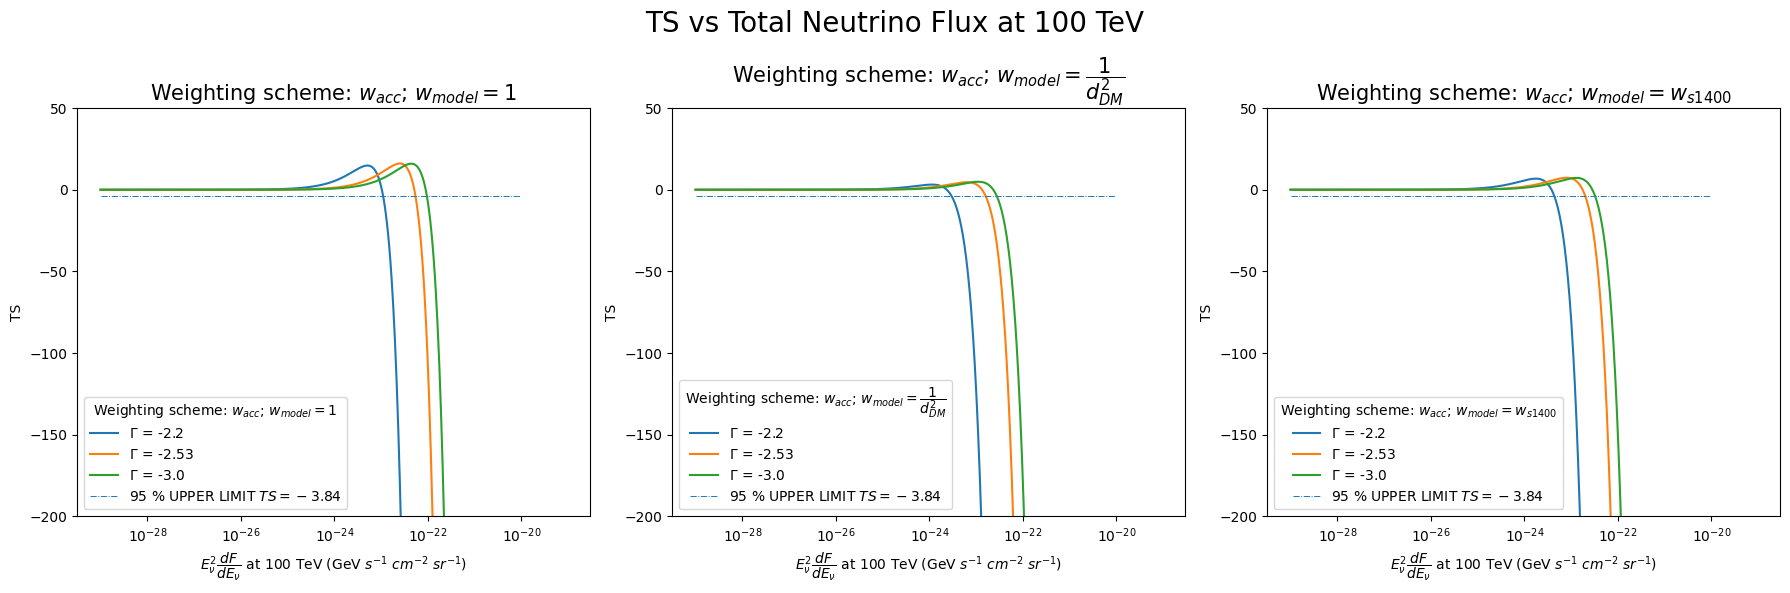

In [59]:
plt.style.use('default')
fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in [ 1, 2, 3]:#range(4):
    # axs[0,0].plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))    #in GeV

    axs[0].plot(e2dfde[gamma]/1e9, all_TSS[1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1].plot(e2dfde[gamma]/1e9, all_TSS[2][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[2].plot(e2dfde[gamma]/1e9, all_TSS[3][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

axs[0].set_title('Weighting scheme: $w_{acc}$; $w_{model} = 1$', fontsize=15)
axs[1].set_title('Weighting scheme: $w_{acc}$; $w_{model} = \dfrac{1}{d_{DM}^2}$' , fontsize=15)
axs[2].set_title('Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$', fontsize=15)




axs[0].hlines(-3.84, 1e-29, 1e-20, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
axs[1].hlines(-3.84, 1e-29, 1e-20, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
axs[2].hlines(-3.84, 1e-29, 1e-20, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')

axs[0].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = 1$')
axs[0].set_xscale('log')
axs[0].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ at 100 TeV (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)')
axs[0].set_ylabel('TS')
# axs[0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0].set_ylim(-200, 50)
# axs[0].set_xlim(5e-20, 1e-13)

axs[1].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} =\dfrac{1}{d_{DM}^2}$')
axs[1].set_xscale('log')
axs[1].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ at 100 TeV (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)')
axs[1].set_ylabel('TS')
# axs[1].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[1].set_ylim(-200, 50)
# axs[1].set_xlim(5e-20, 1e-13)

axs[2].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$')
axs[2].set_xscale('log')
axs[2].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ at 100 TeV (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)')
axs[2].set_ylabel('TS')
# axs[2].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[2].set_ylim(-200, 50)
# axs[2].set_xlim(5e-20, 1e-13)

plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontsize=20)

plt.tight_layout()
plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}_spl.png')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}_spl.png\nDONE')

In [136]:
# @vectorize([float64(float64, float64, float64, float64)], nopython=True)
@njit
def dfde_ul_vec(enu, gamma, phi, flux):
    return np.outer(phi, (enu/flux)**gamma)

In [117]:
dfde_ul_vec(enus, -2, 1e15)

array([[9.95405417e+20, 9.95368755e+20, 9.95332094e+20, ...,
        1.00468980e+05, 1.00465279e+05, 1.00461579e+05]])

In [218]:
all_diff_flux = []
for gamma in [-2.37-0.05, -2.37, -2.37+0.04]:
    # temp = np.multiply(temp, 1e9**(-2))
    all_diff_flux.append(np.ravel(np.square(e_decade) * dfde(np.array(e_decade), gamma, 1.36*1e-18)))
        
all_diff_flux = np.array(all_diff_flux, dtype=np.float64)
all_diff_flux/=1e18
all_diff_flux

array([[3.57716447e-08, 1.36000000e-08, 5.17057579e-09, 1.96579809e-09,
        7.47375588e-10],
       [3.18815119e-08, 1.36000000e-08, 5.80148146e-09, 2.47479317e-09,
        1.05569608e-09],
       [2.90762844e-08, 1.36000000e-08, 6.36119792e-09, 2.97535581e-09,
        1.39167847e-09]])

all_diff_flux = []        
all_diff_flux = 3 * np.square(e_decade)* dfde(np.array(e_decade), -2.37, 1.36*1e-18)
all_diff_flux /=1e18


In [219]:
np.log10(e_decade)

array([13., 14., 15., 16., 17.])

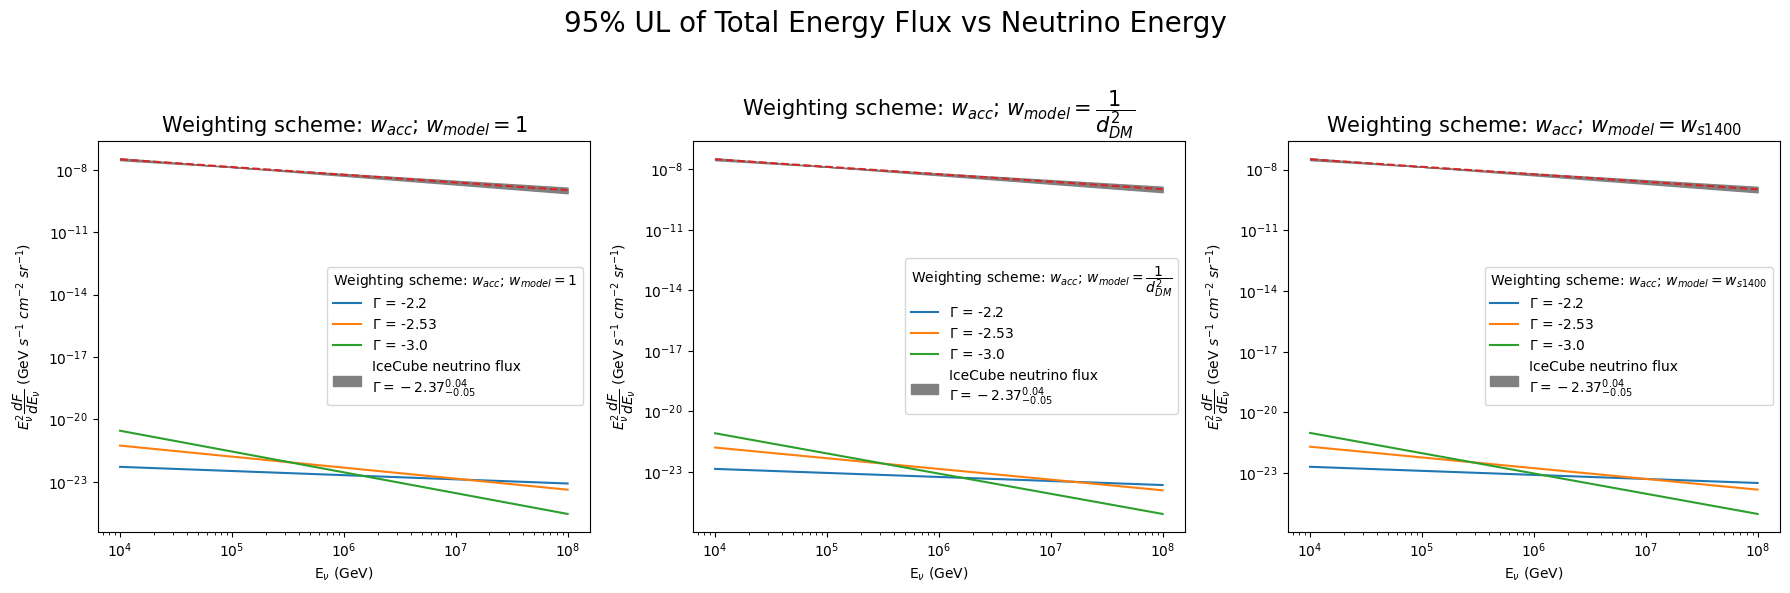

In [223]:
#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))


for gamma in range(1, len(gamma_arr)):

    axs[0].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[0][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[1][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[2].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[2][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

    # axs[0].plot(np.divide(e_decade, 1e9), all_diff_flux[gamma - 1], ls=':', c='k')
    
    # axs[1].plot(np.divide(e_decade, 1e9), all_diff_flux[gamma - 1], ls=':', c='k')
    
    # axs[2].plot(np.divide(e_decade, 1e9), all_diff_flux[gamma - 1], ls=':', c='k')

axs[0].fill_between(np.divide(e_decade, 1e9), all_diff_flux[0], all_diff_flux[-1], label='IceCube neutrino flux\n$\Gamma = -2.37^{0.04}_{-0.05}$', color='grey')
axs[1].fill_between(np.divide(e_decade, 1e9), all_diff_flux[0], all_diff_flux[-1], label='IceCube neutrino flux\n$\Gamma = -2.37^{0.04}_{-0.05}$', color='grey')
axs[2].fill_between(np.divide(e_decade, 1e9), all_diff_flux[0], all_diff_flux[-1], label='IceCube neutrino flux\n$\Gamma = -2.37^{0.04}_{-0.05}$', color='grey')

axs[0].plot(np.divide(e_decade, 1e9), all_diff_flux[1], ls='--')
axs[1].plot(np.divide(e_decade, 1e9), all_diff_flux[1], ls='--')
axs[2].plot(np.divide(e_decade, 1e9), all_diff_flux[1], ls='--')

axs[0].set_title('Weighting scheme: $w_{acc}$; $w_{model} = 1$', fontsize=15)
axs[1].set_title('Weighting scheme: $w_{acc}$; $w_{model} = \dfrac{1}{d_{DM}^2}$' , fontsize=15)
axs[2].set_title('Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$', fontsize=15)

leg = axs[0].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = 1$')
leg._legend_box.align = "left"
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[0].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)")
# axs[0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
# axs[0].set_ylim(1e-19, 1e-6)

leg = axs[1].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} =\dfrac{1}{d_{DM}^2}$')
leg._legend_box.align = "left"
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[1].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)")

leg = axs[2].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$')
leg._legend_box.align = "left"
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[2].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)")

plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy\n', fontsize=20)
plt.tight_layout()
plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}_spl.png')
plt.show()



In [ ]:
# plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']
# # plt.plot(e_decade, temp, 'o-')
# # plt.figure(figsize=(8, 6))
# # for gamma in range(1, len(gamma_arr)):
# #     plt.plot(np.divide(e_decade, 1e9), all_diff_flux[gamma], label=f'$\Gamma$ = {gamma_arr[gamma]}')
    
# for ws in range(3):
#     plt.figure(figsize=(8, 6))
#     for gamma in range(1, len(gamma_arr)):
#         plt.plot(np.divide(e_decade, 1e9), all_UL[ws][gamma], label=f'$\Gamma$ = {gamma_arr[gamma]}')

#     plt.legend()
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('E$_{\u03BD}$ (GeV)')
#     plt.ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV $s^{-1}$ $cm^{-2}$ $sr^{-1}$)")
#     plt.title("95% UL of Total Energy Flux vs Neutrino Energy\nWeighting scheme: " + plttitles[ws])
#     plt.savefig(f'outputs/UL_{ws}_spl.png', facecolor='white')

In [37]:
arr

array([3.69109892e+45, 9.89402632e+44, 2.08011009e+44, 1.19613689e+44])